1. Introduction  
In this project, we intend to assess the impact of energy consumption on air quality by state. Specifically, we used the total energy consumption by state and PM 2.5 as an indicator of air quality in each state in 2016. We collected data from different sources and imported cleaned data into our Air Quality Comparison database. Using SQL queries to extract data from the database, we analyzed and visualized results with Python matplotlib library and sklearn linear regression model to find if there is a correlation between energy consumption and air quality.  

2. Data Sources  
Air Quality 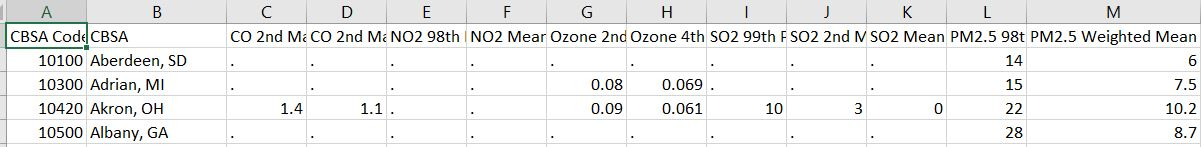
Energy Consumption per Capita 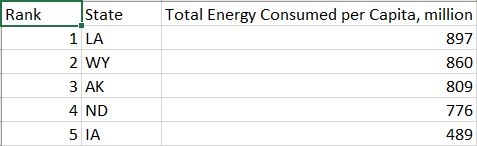
Population 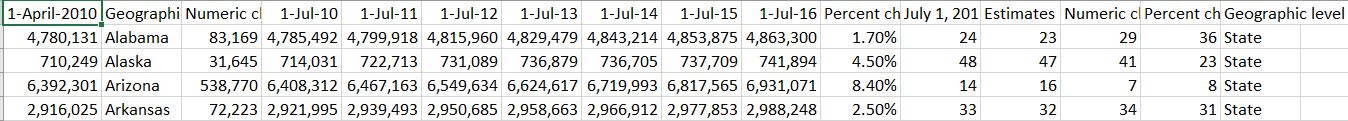
State Table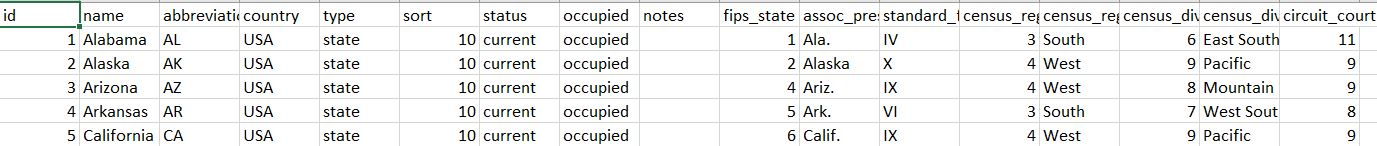
We have four datasets from four sources. The first dataset from the U.S. Energy Information Administration contains the energy consumption per capita by state in 2016. The second dataset provides the estimates of the population for every state in 2016. To obtain the total energy consumption by states, we multiply the energy consumption per capita and population estimation according to corresponding states and can obtain the estimates of total energy consumption by states in 2016. The third dataset from U.S. Environmental Protection Agency contains the emission records of several kinds of gases and particles of some cities in each state in 2016, and we choose to use the weighted average PM 2.5 to assess air quality. The fourth dataset contains current names, abbreviations, and region for states in the United States.

3. Workflow  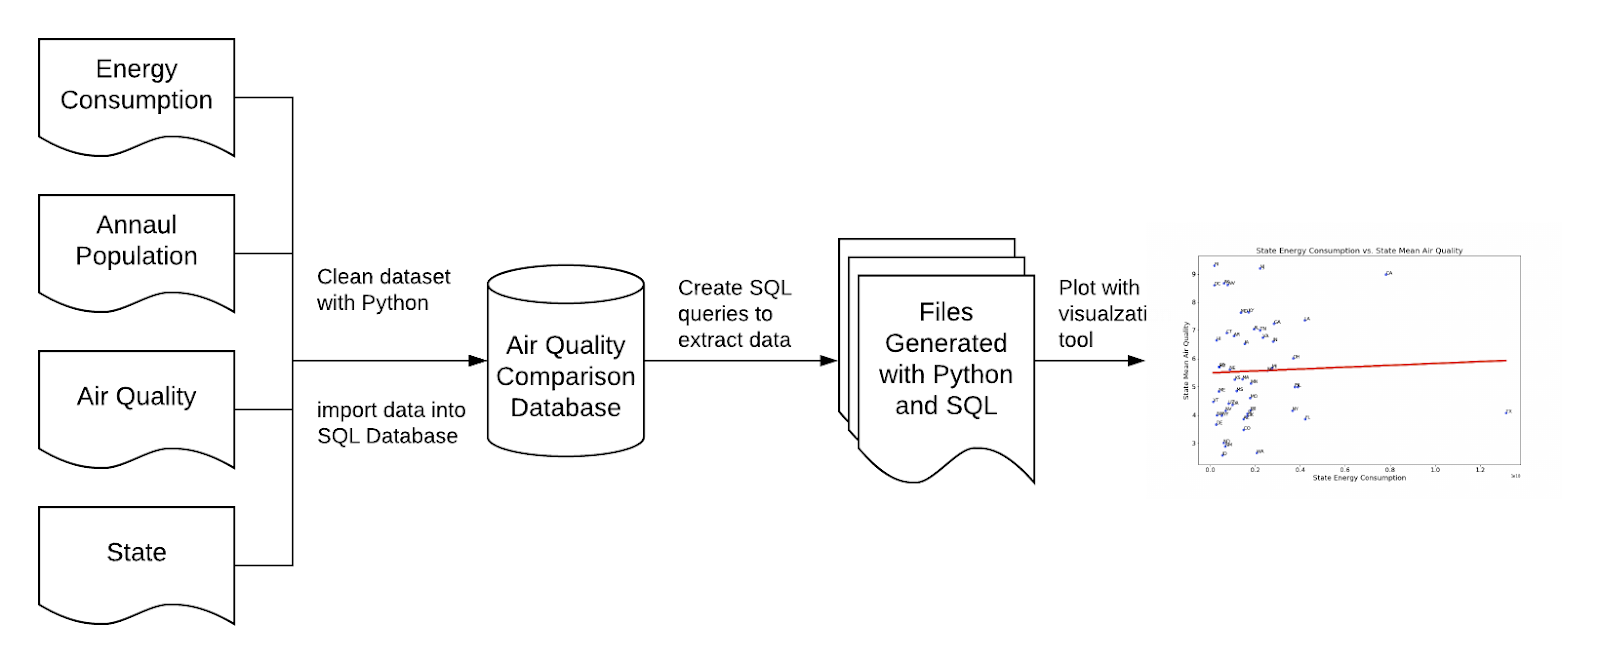
First, we will use Python to read our csv files, create database and proper tables. Then, we will load needed data columns of csv files into tables. Next, we will extract data with correct SQL query to get total energy consumption by state and mean air quality in 2016. Finally, we will generate a plot showing our results

4. ER Diagram 
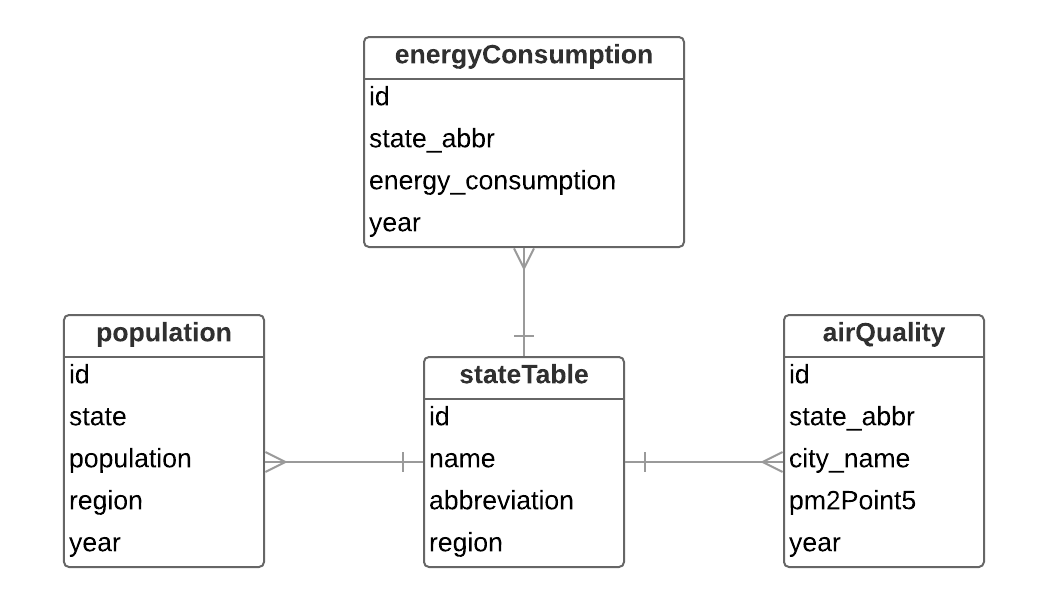  

stateTable: has_many energyConsumption   
energyConsumption: belongs to stateTable

stateTable: has_many poluation population   
population: belongs to stateTable
 
stateTable: has many airQuality   
airQuality: belongs to stateTable

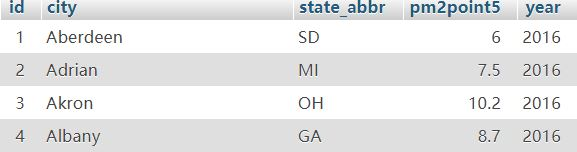  
airQuality table  
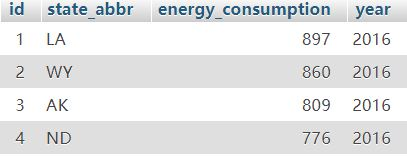  
energyConsumtion table  
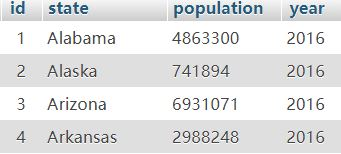  
population table   
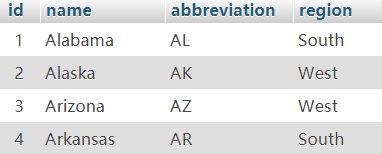
stateTable

5. Code for loading csv into database and description

In [1]:
import pprint
import csv
import pymysql

In [2]:
# open first csv file of state table data 
with open('state_table.csv',mode='r',encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    myCSVReader=list(myCSVReader)
    for row in myCSVReader[:2]:
        pprint.pprint(row)

OrderedDict([('id', '1'),
             ('name', 'Alabama'),
             ('abbreviation', 'AL'),
             ('country', 'USA'),
             ('type', 'state'),
             ('sort', '10'),
             ('status', 'current'),
             ('occupied', 'occupied'),
             ('notes', ''),
             ('fips_state', '1'),
             ('assoc_press', 'Ala.'),
             ('standard_federal_region', 'IV'),
             ('census_region', '3'),
             ('census_region_name', 'South'),
             ('census_division', '6'),
             ('census_division_name', 'East South Central'),
             ('circuit_court', '11')])
OrderedDict([('id', '2'),
             ('name', 'Alaska'),
             ('abbreviation', 'AK'),
             ('country', 'USA'),
             ('type', 'state'),
             ('sort', '10'),
             ('status', 'current'),
             ('occupied', 'occupied'),
             ('notes', ''),
             ('fips_state', '2'),
             ('assoc_press', 'Alaska'

In [3]:
# write into SQL database table "stateTable"
# need name, abbreviation, and census_region_name

connection = pymysql.connect(host="mariadb",
            user="root",  # mysql user
            passwd="",  # mysql passd
            db="my_project",
            autocommit=True,
            cursorclass=pymysql.cursors.DictCursor
            )

cursor = connection.cursor()

cursor.execute("TRUNCATE stateTable")

with open('state_table.csv',mode='r',encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    

    sql = """INSERT INTO stateTable (name, abbreviation, region) VALUE (%(name)s,%(abbreviation)s,%(region)s)"""

    for row in myCSVReader:
        
        param_dict = {'name': row['name'],
                      'abbreviation': row["abbreviation"],
                      'region': row["census_region_name"]}
        cursor.execute(sql, param_dict)

The population file includes a population of seven years in the US states, and we chose to use the value of 2016. Because population numbers contain separators (“,”), we first remove the separators and then convert it into integers to write it into the database. We use encoding “utf-8-sig” to make the columns can be correctly read. 

In [4]:
# open first csv file of population data 
# need 1-Jul-16 population, and state
# mannuly change the name of 'Geographic name' of District of Columbia to Washington DC in order to be consistent to the name in stateTable

with open('Annual_Population_Estimates_data.csv', mode='r',encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    myCSVReader=list(myCSVReader)
    for row in myCSVReader[:2]:
        pprint.pprint(row)

OrderedDict([('1-April-2010 base estimate', '4,780,131'),
             ('Geographic name', 'Alabama'),
             ('Numeric change', '83,169'),
             ('1-Jul-10', '4,785,492'),
             ('1-Jul-11', '4,799,918'),
             ('1-Jul-12', '4,815,960'),
             ('1-Jul-13', '4,829,479'),
             ('1-Jul-14', '4,843,214'),
             ('1-Jul-15', '4,853,875'),
             ('1-Jul-16', '4,863,300'),
             ('Percent change', '1.70%'),
             ('July 1, 2016 (rank)', '24'),
             ('Estimates base (rank)', '23'),
             ('Numeric change (rank)', '29'),
             ('Percent change (rank)', '36'),
             ('Geographic level', 'State')])
OrderedDict([('1-April-2010 base estimate', '710,249'),
             ('Geographic name', 'Alaska'),
             ('Numeric change', '31,645'),
             ('1-Jul-10', '714,031'),
             ('1-Jul-11', '722,713'),
             ('1-Jul-12', '731,089'),
             ('1-Jul-13', '736,879'),
          

In [5]:
# write into SQL database table "population"

cursor.execute("TRUNCATE population")

with open('Annual_Population_Estimates_data.csv', mode='r', encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
    

    sql = """INSERT INTO population(state, population, year) VALUE (%(state)s,%(population)s,%(year)s)"""
    
    year = 2016
    
    for row in myCSVReader:       
        param_dict = {'state': row["Geographic name"],
                      'population': int(row["1-Jul-16"].replace(',', '')),
                       'year': year}
        cursor.execute(sql, param_dict)

In [6]:
# open second csv file of energy consumption per capita by state
# need total energy consumed per capita, and state

with open('Total Energy Consumed per Capita-StateRankings 2016.csv', mode='r', encoding='utf-8-sig') as csvfile:
  
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  myCSVReader=list(myCSVReader)
  for row in myCSVReader[:2]:
        pprint.pprint(row)

OrderedDict([('Rank', '1'),
             ('State', 'LA'),
             ('Total Energy Consumed per Capita, million Btu', '897'),
             ('Note: Rankings are based on the full source data values.', '')])
OrderedDict([('Rank', '2'),
             ('State', 'WY'),
             ('Total Energy Consumed per Capita, million Btu', '860'),
             ('Note: Rankings are based on the full source data values.', '')])


In [7]:
# write into SQL database table "energyConsumption"

cursor.execute("TRUNCATE energyConsumption")

with open('Total Energy Consumed per Capita-StateRankings 2016.csv', mode='r', encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

    sql = """INSERT INTO energyConsumption(state_abbr, energy_consumption, year) VALUE (%(state_abbr)s,%(energy_consumption)s,
    %(year)s)"""
    
    year = 2016
    
    for row in myCSVReader:
        param_dict = {'state_abbr': row["State"],
                      'energy_consumption': row["Total Energy Consumed per Capita, million Btu"],
                     'year': year}
        cursor.execute(sql, param_dict)

The air quality file contains location and air quality information. However, the location column “CBSA” in the dataset includes both the city name and state name and we split the “CBSA” by “,” to put cities and states into different columns. And some records show that some rows have multiple states that share the same measurement. So, we split such ‘CBSA’ rows by “-” and used a for loop to iterate over all items. Then we imported into the air quality table in the database.

In [8]:
# open third csv file of air quality by regions of states
# need CBSA, and PM2.5 weighted mean 
 
with open('Air Quality2016.csv', mode='r', encoding='utf-8-sig') as csvfile:
  
  myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')
  myCSVReader=list(myCSVReader)
  for row in myCSVReader[:2]:
        pprint.pprint(row)

OrderedDict([('CBSA Code', '10100'),
             ('CBSA', 'Aberdeen, SD'),
             ('CO 2nd Max 1-hr', '.'),
             ('CO 2nd Max 8-hr', '.'),
             ('NO2 98th Percentile 1-hr', '.'),
             ('NO2 Mean 1-hr', '.'),
             ('Ozone 2nd Max 1-hr', '.'),
             ('Ozone 4th Max 8-hr', '.'),
             ('SO2 99th Percentile 1-hr', '.'),
             ('SO2 2nd Max 24-hr', '.'),
             ('SO2 Mean 1-hr', '.'),
             ('PM2.5 98th Percentile 24-hr', '14'),
             ('PM2.5 Weighted Mean 24-hr', '6'),
             ('PM10 2nd Max 24-hr', '65'),
             ('PM10 Mean 24-hr', '20'),
             ('Lead Max 3-Mo Avg', '.')])
OrderedDict([('CBSA Code', '10300'),
             ('CBSA', 'Adrian, MI'),
             ('CO 2nd Max 1-hr', '.'),
             ('CO 2nd Max 8-hr', '.'),
             ('NO2 98th Percentile 1-hr', '.'),
             ('NO2 Mean 1-hr', '.'),
             ('Ozone 2nd Max 1-hr', '0.08'),
             ('Ozone 4th Max 8-hr', '0.069'

In [9]:
# write into SQL database table "airQuality"

cursor.execute("TRUNCATE airQuality")

with open('Air Quality2016.csv', mode='r', encoding='utf-8-sig') as csvfile:
  
    myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

    sql = """INSERT INTO airQuality(city, state_abbr, pm2point5, year) VALUE (%(city)s,%(state_abbr)s,%(pm2point5)s,%(year)s)"""
    
    year = 2016
    
    for row in myCSVReader:
        
        city_state = row["CBSA"].split(', ')
        city = city_state[0]
        state_abbr = city_state[1].split('-')
        
        for state in state_abbr:
            param_dict = {'city': city_state[0],
                      'state_abbr': state,
                      'pm2point5': row["PM2.5 Weighted Mean 24-hr"],
                       'year': year}
            cursor.execute(sql, param_dict)

/usr/local/lib/python3.6/site-packages/pymysql/cursors.py:329: Warning: (1366, "Incorrect double value: '.' for column 'pm2point5' at row 1")
  self._do_get_result()
